# Facial Expression Recognition (FER) without Artificial Neural Networks (spanish version)

Friendly reminder that the English version of this notebook is documented as a Medium post ➡️ that soon will be here

## Introduction

### Data and Machine Learning

Cuando se trata de hablar sobre _**Machine Learning**_, se deja muy en claro que es la ciencia (y el arte) de 
programar computadoras para que aprendan de los datos [1]. Con esta primera definición lo siguiente que se 
piensa es: ¿los datos? ¿las tablas de Excel?

Lo primero que se piensa (o al menos fue lo primero que yo pensé) es en **datos estructurados**, a lo que 
generalmente se le conoce como **tabla de datos**. Los archivos **.xlsx** o **.csv** son ejemplos de lo que 
la mayoría de las personas conoce como **datos**.

Sin embargo, se dice que hay datos en todos lados, por lo que otra forma de representar datos es a través de 
**imágenes**, al final y al cabo, las imágenes son arreglos de números conocídos como píxeles.

<img src="https://media.geeksforgeeks.org/wp-content/uploads/Pixel.jpg" width = 700px></img>

Las tareas entre una computadora y las imágenes y videos digitales se encuentran englobadas dentro del 
campo de la **Visión por Computadora**, y cuando la Visión por Computadora se junta con _**Deep Learning**_ 
(un área de _Machine Learning_ dedica a las **Redes Neuronales Artificiales**) surgen interesantes 
aplicaciones y proyectos.

Existen retos de Visión por Computadora, como la **clasificación** de imágenes, donde _Deep Learning_ ha sido 
de gran apoyo gracias a la implementación de **Redes Neuronales Convolucionales (CNN)**. Este tipo de 
arquitectura usa el concepto de convolución para extraer atributos de la imagen que sean caraterísticos 
para su clasificación.

### Classical Machine Learning instead of Convolutional Neural Networks

Es obvio que ante cualquier problema de clasificación de imágenes, las CNN sean las más adecuadas para 
resolverlo, sin embargo, en este proyecto quize encontrar una solución con algoritmos de Machine Learning
_clásicos_.

Quizás para algunas personas leyendo esto se les haga raro, pero ténganme paciencia, que gracias a esta 
manera de resolver este problema, pude experimentar con uno de los algoritmos más elegantes de _Machine_ 
_Learning_ y conocí otro que ayuda a extraer información de las imágenes.

## Disclaimer

Este documento muestra una manera en la que se puede resolver el problema de Reconocimiento de Emociones (FER). La metodología 
esta basada en el artículo [_**Facial Expression Classification Based on SVM, KNN and MLP Classifiers**_](https://ieeexplore.ieee.org/abstract/document/8723728) 
por Hivi Ismat Dino y Maiwan Bahjat Abdulrazzaq.

## The data and The Curse of Dimensionality 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='serif')

import warnings
warnings.filterwarnings('ignore') 

> El proceso que tuvieron las imágenes para ser _transformadas_ a archivos CSV se encuentra registrado en el archivo **.py** 
> llamado **create_database_train_test.py**, para concer como se hizo el código se puede entrar a siguiente enlace de 
> [aquí](https://github.com/isaacarroyov/fer_without_ann/tree/main/scripts)
>
> Las imágenes y los archivos CSV se pueden descargar [aqui](https://1drv.ms/u/s!AvynzzoVDsC2gsVFxC2jhtMtqEhIwQ?e=OasASO)

In [2]:
# Load data
df_train = pd.read_csv('../data/training_data.csv',header=None)
df_test = pd.read_csv('../data/testing_data.csv',header=None)

X_train = df_train.iloc[:,1:].values
y_train = df_train.iloc[:,0].values

X_test = df_test.iloc[:,1:].values
y_test = df_test.iloc[:,0].values


print(f'Our dataset has {df_train.shape[1]-1} features')

Our dataset has 4096 features


Así como la física a escalas extremadamente pequeñas (Física Cuántica) se comporta diferente a la física que 
de las cosas cotidianas y de tamaño "normal" (Física Clásica) lo mismo pasa con las **dimensiones**.

Un vector en **dos dimensiones** está compuesto de **dos componentes**:

$$\vec{v}_{\mathbb{R}^2} = \begin{bmatrix}
x_1 \\
x_2 
\end{bmatrix}$$

un vector de **tres dimensiones** está compuesto de **tres componentes**:

$$\vec{v}_{\mathbb{R}^3} = \begin{bmatrix}
x_1 \\
x_2 \\
x_3
\end{bmatrix}$$

y un vector de **$n$ dimensiones** (también llamado hipervector) está compuesto de **$n$ componentes**:

$$\vec{v}_{\mathbb{R}^n} = \begin{bmatrix}
x_1 \\
x_2 \\
\vdots\\
x_n
\end{bmatrix}$$


Algo interesante de las **altas dimensiones** surgen dos cosas:

* La mayoría de los puntos se encuentran muy cerca de la superficie del hipercubo [1].
* La distancia promedio entre dos puntos del hipercubo es alta. Por ejemplos para un hipercubo unitario de 
$1\times 10^6$ dimensiones es de aproximadamente 408.25, mientras que para un cubo unitarios 
de tres dimensiones es de 0.66 [1]

¿Por qué sucederá todo esto? Bueno, hay mucho espacio cuando se esta en muchas dimensiones, como resultado, los datos están
muy poco densos: muchos de los datos de entrenamiento estan lejos unos de los otros. Esto también significa que nuevos datos
puedan estar muy lejos de los datos de entrenamiento haciendo que las predicciones sean menos confiables en comparación con
datos con menos dimensiones [1]

### ¿Cómo se puede solucionar?

Una manera para eliminar este obstáculo es incrementar el número de instancias para tener una mayor densidad 
de puntos, sin embargo en la práctica no es muy viable [1]. 

La siguiente opción parece ser muy obvia pero es **reducir las dimensiones** y para ello podemos tomar uno de 
varios caminos, pero para este trabajo se exploran dos:

* _Feature detection_
* _Dimensionality Reduction_

## Feature Detector: Histogram of Oriented Gradients (HOG)

_**H**istograms of **O**riented **G**radients_ o **HOG** es un _feature descriptor_ propuesto por Dalal et al en 2005 [2]. 
Este descriptor computa el cambio de los valores de los pixeles alrededor de uno en interés. Este cambio esta dado por un 
**gradiente** $\vec{G}$ (vector de cambio) cuya magnitud ($m$) y ángulo ($\theta$) están dados por las ecuaciones 1 y 2:

$$m(x,y) = \sqrt{\vec{G}(x,y)\cdot\vec{G}(x,y)} = \sqrt{\left(G_{x}(x,y)\right)^{2} + \left(G_{y}(x,y)\right)^{2}} \tag{1}$$

$$\theta(x,y) = \tan^{1} \frac{G_y (x,y)}{G_x (x,y) } \tag{2}$$

Para conocer más a fondo como funciona este algoritmo, pueden visitar el siguiente video [aquí](https://youtu.be/XmO0CSsKg88).

### Ejemplo con `skimage`

In [3]:
from skimage.feature import hog

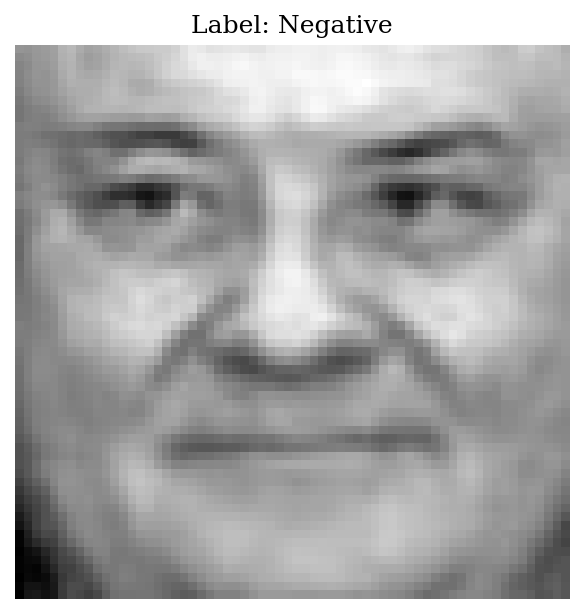

In [4]:
# Select a random image
n = np.random.randint(df_train.shape[0])
prueba = X_train[n].reshape((64,64))
#plt.figure(dpi=150)
plt.imshow(prueba,cmap='gray')
if y_train[n] == 1:
    target = 'Positive'
else:
    target = 'Negative'
plt.title(f"Label: {target}")
plt.axis('off')
plt.show()

HOG feature vector con 1764 features


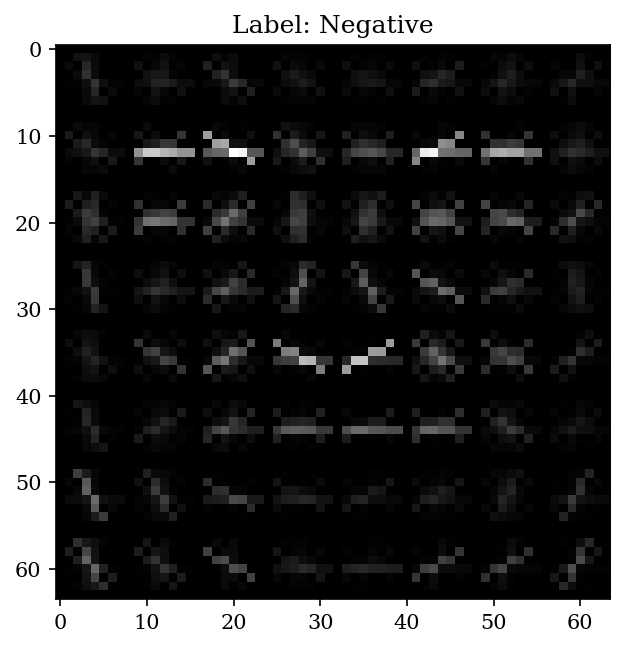

In [5]:
hog_feature_vector, hog_image = hog(prueba, 
                                    orientations=9, 
                                    pixels_per_cell=(8,8), 
                                    cells_per_block=(2,2),
                                    visualize=True, # True if you want the HOG image, default value is False
                                      )
print(f"HOG feature vector con {len(hog_feature_vector)} features")
#plt.figure(dpi=150)
plt.imshow(hog_image,cmap='gray')
plt.title(f"Label: {target}")
plt.show()

Se observa que se redujeron arriba del 50% , casi un 60% de _features_. De 4096 _features_ a 1764 _features_. 

Lo interesante, es que viendo la imagen, se puede distinguir el tipo de emoción, ya que los gradientes nos muestran 
algo similar al contorno de la figura, la dirección de la luminosidad de los pixeles.

## Dimensionality Reduction: Principal Component Analysis

In [6]:
from sklearn.decomposition import PCA

Para poder optimizar el entrenamiento del modelo de _Machine Learning_ se tomará el siguiente paso: **Reducir las dimensiones**.

Es claro que con ayuda del algoritmo HOG, las dimensiones pasaron de 4096 a 1764 conservando una gran cantidad de la información que 
contiene la imagen, sin embargo, se sigue contando con una **enorme** cantidad de _features_.

Para esta tarea se usará uno de los algoritmos de reducción de dimensionalidad (y de aprendizaje no supervisado) más 
conocidos: **PCA**

En términos generales, el objetivo de **PCA** es poder encontrar una proyección lineal que pueda **conservar la mayor cantidad de 
información**. Una de la maneras en las que se puede ver el enfoque de _preservar información_, es que al buscar el plano donde 
se hará la nueva proyección de los datos, encuentre aquel que pueda **maximizar la varianza** [1]

Así como en el algoritmo de _**K-Means**_ se tiene que dar _a priori_ el número de _clusters_ que se desean y por ende hay 
que encontrar un criterio para concer el número óptimo de _clusters_, lo mismo sucede con **PCA**. Para encontrar el número de 
dimensiones ideal, hay que saber cuando la **_explained variance_** deja de crecer significativamente [1], tal como se muestra en 
la siguiente figura.

<img src="../images/TDS-fer_without_ann_01.png" width = 700px></img>

Otra manera de obtener el **número óptimo de dimensiones** es especificando el porcentaje de información que queremos conservar. 
Esta tarea es posible gracias a la librería de **Scikit-Learn**, ya que en vez de específicar el número entero de dimensiones en 
**`n_components`**, se puede escribir como valor flotante el porcentaje de información a conservar.

Para este proyecto se tratará de **conservar el 90% de la información del _data set_**

In [7]:
# Feature Descriptor
from OwnTransformers.ImageDescriptors import DescriptorHOG
hog_descriptor = DescriptorHOG()
X_train_hog = hog_descriptor.transform(X=X_train)

# Dimensionality reduction
porc_inf = 0.90
pca = PCA(n_components=porc_inf, svd_solver='full')
X_train_hog_reduced = pca.fit_transform(X_train_hog)

dim_sample_hog = X_train_hog.shape[1]
dim_sample_hog_reduced = X_train_hog_reduced.shape[1]
print(f"Applying PCA (preserving {porc_inf*100}% of information), the data set reduces from {dim_sample_hog} to {dim_sample_hog_reduced} features")
print(f"Aproximately {round(1- (dim_sample_hog_reduced/dim_sample_hog),3)*100}% of the number of its previous features")

Applying PCA (preserving 90.0% of information), the data set reduces from 1764 to 329 features
Aproximately 81.3% of the number of its previous features


## Classifier: Support Vector Machine

In [8]:
from sklearn.svm import SVC

El algoritmo de _**Support Vector Machine**_ es uno de los algoritmos más elegantes de _Machine Learning_, también uno de los más 
poderosos y usados en diferentes problemáticas; con un buen pre-procesamiento de los datos, las predicciones llegan a ser 
similares a los de las redes neuronales, un ejemplo se muestra en el artículo 
_Dimensionality Reduction for Handwritten Digit Recognition_ [3]

De las particularidades más interesantes de este algoritmo está el _kernel trick_, que en pocas palabras, puede transformar las 
dimensiones de los datos para que pueda contar el hiperplano que pueda clasificar los datos, sin comprometer el esfuerzo 
computacional del algoritmo.

Existen diferentes tipos de _kernels_, pero para este problema se intentará con el **Gaussian _Radial Basis Function_ kernel**. Esta 
es un técnica usada cuando los datos con los que se cuenta no son linealmente separables [1]. 

Lo que hace este _kernel_ es agregar _features_ a través de una función de similitud (la **Gaussian _Radial Basis Function_**) que 
mide cuanto se parece una instancia a una determinada región o _landmark_ [1].

<img src="../images/TDS-fer_without_ann_02.png" width=700px></img>

En la imagen superior se puede ver como se transforma un conjunto de datos que **no son linealmente separables** a otro que 
**si es linealmente separables** con la función **Gaussian _Radial Basis Function_** 

($x_1$ es la _feature_ original, $x_2$ y $x_3$ son las _features_ creadas por la función)

La implementación de este algoritmo en Scikit-Learn es declarando **`kernel = 'rbf'`** en el modelo

### Hiper-parámetros de `SVC` con `kernel = 'rbf'`

La Ecuación 3 es el _kernel_ de **Gaussuan _Radial Basis Function_**

$$ \mathrm{K} (\mathbf{a}, \mathbf{b}) = \exp\left(-\gamma ||\mathbf{a}-\mathbf{b}||^{2}\right) \tag{3}$$

donde $\mathbf{a}$ y $\mathbf{b}$ son vectores, uno de ellos (normalmente el segundo) es el _landmark_; y $\mathbf{\gamma}$ 
**es uno de los hiper-parámetros**.

Incrementar $\gamma$ hace que la forma de campana de la curva sea más angosta; como resultado el rango de influencia de cada instancia 
es menor causando que el _decision boundary_ sea un poco más irregular, pegándose a las instancias individuales. Caso contrario a 
cuando $\gamma$ decrece, la forma de la curva es más amplia; las instancias tiene un rango de influencia mayor y el _decision boundary_ 
es un poco más "suave".

## The Pipeline

Es importante inicorporar todos los procesos de extracción de _features_ dentro de un mismo Pipeline. Para ello se crea una clase
para _Histograms of Oriented Gradients_

La clase esta almacenada [**aquí**](https://github.com/isaacarroyov/fer_without_ann/blob/main/notebooks/OwnTransformers/ImageDescriptors.py) y 
se importa como

```Python
from OwnTransformers.ImageDescriptors import DescriptorHOG
```

Es importante que todas las variables se encuentren en una misma escala, por ello se van a estandarizar con 
**`StandardScaler`**

In [9]:
from OwnTransformers.ImageDescriptors import DescriptorHOG
from sklearn.preprocessing import StandardScaler # Adding standardization --> all attributes are on the same scale
from sklearn.pipeline import Pipeline

El modelo seria el siguiente:


```Python
Pipeline(
    steps= [
            ('hogdescriptor', DescriptorHOG()),
            ('pca', PCA(n_components=0.9, svd_solver='full')),
            ('scaler', StandardScaler()),
            ('svm', SVC(kernel='rbf', gamma= NUMBER, C = NUMBER))
            ]
        )
```

## First model

In [10]:
gamma_01 = 0.1
C_01 = 100
model_01 = Pipeline(steps= [
    ('hogdescriptor', DescriptorHOG()),
    ('pca', PCA(n_components=0.9, svd_solver='full')),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=C_01, gamma=gamma_01))
    ])

### Training the model

In [11]:
model_01.fit(X=X_train, y=y_train)

Pipeline(memory=None,
         steps=[('hogdescriptor',
                 DescriptorHOG(hog_block_norm='L2', hog_cells_per_block=(2, 2),
                               hog_orientations=9, hog_pixels_per_cell=(8, 8),
                               img_dim=(64, 64))),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.9,
                     random_state=None, svd_solver='full', tol=0.0,
                     whiten=False)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm',
                 SVC(C=100, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.1, kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

### Testing the model

In [12]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score, accuracy_score, f1_score, recall_score

In [13]:
# Make predictions
y_predict_01 = model_01.predict(X=X_test)

# Create ROC Curve + ROC AUC score
y_scores_01 = model_01.decision_function(X_test)
fpr_01, tpr_01, _ = roc_curve(y_true=y_test, y_score=y_scores_01)
roc_auc_01 = roc_auc_score(y_true=y_test, y_score= y_scores_01)

In [14]:
# Create Confussion Matrix
confMatrix = pd.DataFrame( confusion_matrix(y_true=y_test, y_pred=y_predict_01),
                         index = ['Negative', 'Positive'],
                         columns = ['Negative', 'Positive']
                         )
confMatrix.index.name = 'Actual'
confMatrix.columns.name = 'Predicted'

In [15]:
# Print classificacion metrics
print(f'Accuracy of the model: {accuracy_score(y_test,y_predict_01)}')
print(f'Precision of the model: {precision_score(y_test,y_predict_01)}')
print(f'Recall of the model: {recall_score(y_test,y_predict_01)}')
print(f'F1-Score of the model: {f1_score(y_test,y_predict_01)}')

Accuracy of the model: 0.7196233292831106
Precision of the model: 0.0
Recall of the model: 0.0
F1-Score of the model: 0.0


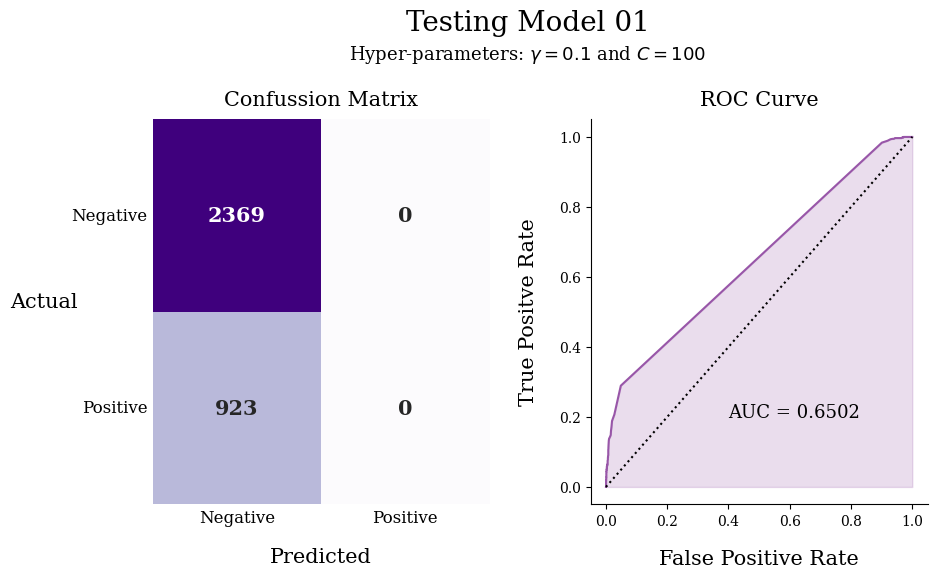

In [27]:
# Plot Confussion Matrix and ROC Curve
fig,(ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
fig.subplots_adjust(wspace=0.3)

# Heatmap
sns.heatmap(data=confMatrix, annot=True, fmt='d', square=False, cmap='Purples',vmin=0, cbar=False, ax=ax1,
annot_kws = {'size': 15, 'fontdict':{'fontweight':'bold'}}
)
# ROC Curve
ax2.plot(fpr_01, tpr_01, color='#9856A8')
ax2.fill_between(x=fpr_01, y1=tpr_01, color = '#9856A8', alpha=0.2)
ax2.text(x=0.4,y=0.2, s=f'AUC = {round(roc_auc_01,4)}', fontdict=dict(size=13))
# Randon classifier
ax2.plot([0,1],[0,1], linestyle='dotted', color='black')


fig.suptitle('Testing Model 01', size = 20,y=1.1)
fig.text(x=0.5,y=1, s=f'Hyper-parameters: $\gamma = {gamma_01}$ and $C = {C_01}$', ha='center', fontdict=dict(size=13))
ax1.set_title(f"Confussion Matrix", pad=10, size=15)
ax2.set_title('ROC Curve', pad=10, size=15)

ax1.set_ylabel('Actual',rotation=0, labelpad=20, size=15)
ax1.set_xlabel('Predicted', labelpad=15, size=15)
ax1.tick_params(axis='both', which='both', length=0)
ax1.tick_params(axis='y', rotation=0)
ax1.tick_params(labelsize=12)

ax2.set_xlabel('False Positive Rate', labelpad=15, size=15)
ax2.set_ylabel('True Positve Rate', labelpad=15, size=15)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.show()

Se obtiene un bajo desempeño con este modelo y sus hiper-parámetros. La matriz de confusión muestra altos **Verdaderos Negativos** que llevan a 
un _accuracy_ alto; sin embargo **no hay detección de verdaderos positivos**, dando como consecuencia las demás metricas con valores de 0.


## Fine-Tune the model

Para mejorar el modelo se pueden cambiar los hiper-parámetros. Hacer esta tarea manualmente y llevar un registro de los desempeños es tedioso y 
cansado, para esto se usa **`GridSearchCV`**. Lo que regresa **`GridSearchCV`** es el modelo entrenado con los mejores hiper-parámetros.

In [17]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [18]:
# Declare grid of hyper-parameters
dict_hyperparams = dict(svm__gamma=[0.001,0.01,0.1], svm__C = [1,10,100,1_000])

# Cross Validation for GridSearchCV
crossVal = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [19]:
model_02 = Pipeline(steps= [
    ('hogdescriptor', DescriptorHOG()),
    ('pca', PCA(n_components=0.9, svd_solver='full')),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
    ])

grid = GridSearchCV(
    estimator= model_02, # Model
    param_grid= dict_hyperparams, # hyper-parameters
    cv= crossVal, # Cross Validation
    n_jobs=-1, # Use all CPU's
    verbose= 5 # Info
)

In [20]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  60 | elapsed: 10.7min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  55 out of  60 | elapsed: 14.6min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 15.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('hogdescriptor',
                                        DescriptorHOG(hog_block_norm='L2',
                                                      hog_cells_per_block=(2,
                                                                           2),
                                                      hog_orientations=9,
                                                      hog_pixels_per_cell=(8,
                                                                           8),
                                                      img_dim=(64, 64))),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=0.9, random_state=None,
                                            svd_so

In [21]:
# Best params
gamma_02 = grid.best_params_['svm__gamma']
C_02 = grid.best_params_['svm__C']

### Testing Model 02

In [22]:
# Make predictions
y_predict_02 = grid.predict(X=X_test)

# Create ROC Curve + ROC AUC score
y_scores_02 = grid.decision_function(X_test)
fpr_02, tpr_02, _ = roc_curve(y_true=y_test, y_score=y_scores_02)
roc_auc_02 = roc_auc_score(y_true=y_test, y_score= y_scores_02)

In [23]:
# Create Confussion Matrix
confMatrix_02 = pd.DataFrame( confusion_matrix(y_true=y_test, y_pred=y_predict_02),
                         index = ['Negative', 'Positive'],
                         columns = ['Negative', 'Positive']
                         )
confMatrix_02.index.name = 'Actual'
confMatrix_02.columns.name = 'Predicted'

In [24]:
# Print classificacion metrics
print(f'Accuracy of the model: {accuracy_score(y_test,y_predict_02)}')
print(f'Precision of the model: {precision_score(y_test,y_predict_02)}')
print(f'Recall of the model: {recall_score(y_test,y_predict_02)}')
print(f'F1-Score of the model: {f1_score(y_test,y_predict_02)}')

Accuracy of the model: 0.9106925880923451
Precision of the model: 0.8661233993015134
Recall of the model: 0.8060671722643553
F1-Score of the model: 0.835016835016835


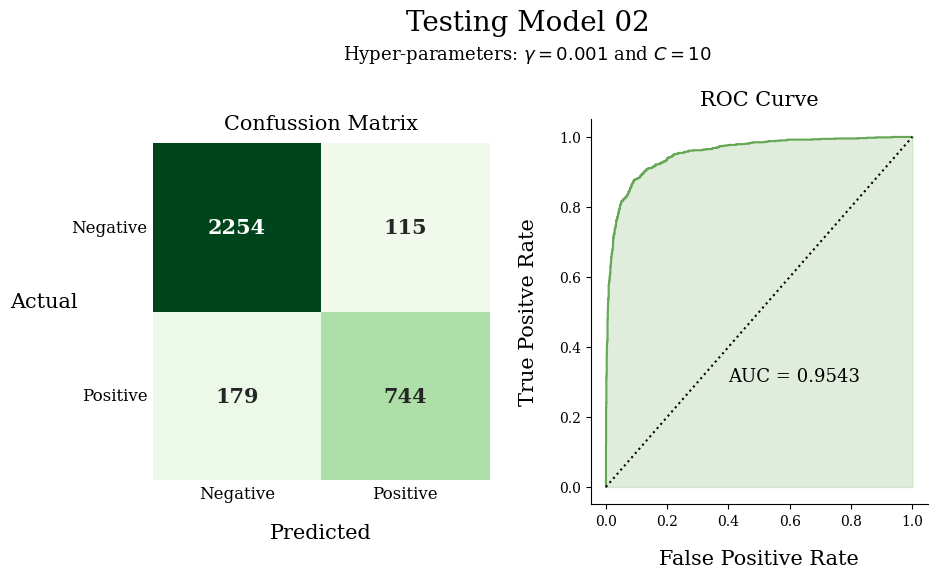

In [26]:
# Plot Confussion Matrix and ROC Curve
fig,(ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
fig.subplots_adjust(wspace=0.3)

sns.heatmap(data=confMatrix_02, annot=True, fmt='d', square=True, cmap='Greens',vmin=0, cbar=False, ax=ax1,
annot_kws = {'size': 15, 'fontdict':{'fontweight':'bold'}}
)

ax2.plot(fpr_02, tpr_02, color='#66A856')
ax2.fill_between(x=fpr_02, y1=tpr_02, color = '#66A856', alpha=0.2)
ax2.text(x=0.4,y=0.3, s=f'AUC = {round(roc_auc_02,4)}', fontdict=dict(size=13))
ax2.plot([0,1],[0,1], linestyle='dotted', color='black')


fig.suptitle('Testing Model 02', size = 20,y=1.1)
fig.text(x=0.5,y=1, s=f'Hyper-parameters: $\gamma = {gamma_02}$ and $C = {C_02}$', ha='center', fontdict=dict(size=13))
ax1.set_title(f"Confussion Matrix", pad=10, size=15)
ax2.set_title('ROC Curve', pad=10, size=15)


ax1.set_ylabel('Actual',rotation=0, labelpad=20, size=15)
ax1.set_xlabel('Predicted', labelpad=15, size=15)
ax1.tick_params(axis='both', which='both', length=0)
ax1.tick_params(axis='y', rotation=0)
ax1.tick_params(labelsize=12)

ax2.set_xlabel('False Positive Rate', labelpad=15, size=15)
ax2.set_ylabel('True Positve Rate', labelpad=15, size=15)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.show()

Tras aplicar **`GridSearchCV`**, se encuentran los mejores hiper-parámetros para el SVM, y a comparación con el modelo anterior, las 
predicciones mejoran por mucho. El modelo logra un gran porcentaje y buen balance para clasificar las caras de clase positiva que son 
realmante correctas de las que se predijeron sin tener muchas falsas alarmas (alto **F1-Score**).

El ROC AUC y la forma la curva ROC muestran un buen modelo de predicción.

## Conclusion

Algunas de las conclusiones que se tienen de este proyecto son:

* El mejor modelo de clasificación es el segundo, donde se tiene un alto valor de **F1-Score**, la métrica idal para priorizar por igual 
la _**Precision**_ y _**Recall**_.

* Reducir las dimensiones ha ayudado a poder reducir el tiempo de entrenamiento, ya que de estar usando las más de cuatro mil _features_ 
iniciales el algoritmo de SVM se hubiese saturado.

* Conocer que son los hiperparámetros y lo que significan en cada tipo de algoritmo de _Machine Learning_ es clave para poder ajustarlos 
y de esa manera conseguir un mejor desempeño del modelo.

* Se aprendieron nuevos y/o reforzaron los conocimientos de conceptos tales como 
    * **Histograms of Oriented Gradients**: Un _feature descriptor_ bastante útil para conocer lo más relevante en una imagen. La creación 
    de una clase para que este descriptor pudiese entrar dentro del Pipeline tiene futuras aplicaciones, ya que se pueden cambiar sus
    hiper-parámetros para mejorar el desemepeño del algún modelo.
    * **Principal Component Analysis**: Aunque elegir el número de dimensiones a reducir puede ser una tarea demasiado subjetiva (detectar 
    el codo de la gráfica), es muy útil poder elegir la proporción de información que se quiere conservar.

* Tomar problemas complejos, que han sido tratados con _Deep Learning_, y tratar de resolverlos con algoritmos de _Machine Learning clásicos_ 
puede ser de gran ayuda para la mejor compresión de conceptos vistos y la aplicación de nuevos. Tambien creo que al hacer esto, se muestra la 
habilidad para resolver problemas al poder tomar diferentes perspectivas ante una misma situación.

## References

**[1]** Géron, A. (2019). _Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, 
and Techniques to Build Intelligent Systems_ (2nd ed.). O’Reilly Media.

**[2]** Dalal, N., & Triggs, B. (2005, June). Histograms of oriented gradients for human detection. In 2005 IEEE computer 
society conference on computer vision and pattern recognition (CVPR'05) (Vol. 1, pp. 886-893). Ieee.

**[3]** Das, A., Kundu, T., & Saravanan, C. (2018). Dimensionality reduction for handwritten digit recognition. EAI Endorsed 
Transactions on Cloud Systems, 4(13).